# Ejercicio 1: Breast cancer

In cancer detection, we want to minimize incorrect negative predictions (i.e. the sick patient is classified as negative) because this diagnosis could lead to serious health problems. Therefore, the most important metric in the application of cancer detection is the recall which objective is to limit the number of false negatives.

## Load data

In [16]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

In [17]:
cancer['target_names']

array(['malignant', 'benign'], dtype='<U9')

**Target**  
'0' => malignant/sick  
'1' => benign/safe

## Preprocessing

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_cancer = pd.DataFrame(data=cancer['data'], columns=cancer['feature_names'])
df_cancer['target'] = cancer['target']

X_train, X_test, y_train, y_test = train_test_split(df_cancer.drop('target', axis=1), df_cancer['target'], test_size=0.3, random_state=42)

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

## Training

In [20]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler

nb_col = X_train.shape[1]

dict_models = [
    {
        'name_clf' : 'SVC (poly)',
        'model': SVC(random_state=42, kernel='poly'),
        'scalers' : {
            'scaler': [MinMaxScaler()],
        },
        'grid' : {
            'model__C': [10**k for k in range(-3, 4)],
            'model__gamma': [10**k for k in range(-3, 4)],
        }
    },

    {
        'name_clf' : 'SVC (linear)',
        'model': SVC(random_state=42, kernel='linear'),
        'scalers' : {
            'scaler': [None, StandardScaler(), MinMaxScaler()],
        },
        'grid' : {
            'model__C': [10**k for k in range(-4, 5)],
            'model__gamma': [10**k for k in range(-4, 5)],
        }
    },

    {
        'name_clf' : 'SVC (rbf)',
        'model': SVC(random_state=42, kernel='rbf'),
        'scalers' : {
            'scaler': [None, StandardScaler(), MinMaxScaler()],
        },
        'grid' : {
            'model__C': [10**k for k in range(-4, 5)],
            'model__gamma': [10**k for k in range(-4, 5)],
        }
    },

    {
        'name_clf' : 'SVC (sigmoid)',
        'model': SVC(random_state=42, kernel='sigmoid'),
        'scalers' : {
            'scaler': [None, StandardScaler(), MinMaxScaler()],
        },
        'grid' : {
            'model__C': [10**k for k in range(-4, 5)],
            'model__gamma': [10**k for k in range(-4, 5)],
        }
    },


]

i had to use only MinMaxScaler with the poly kernel because otherwise it would have taken too much time, in my case it had been running for more than 2 days

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from time import time
from utils import model_evaluation_clf

import warnings
warnings.filterwarnings("ignore")

results = pd.DataFrame(columns=["Model", "CPU time", "Accuracy", "Precision", "Recall", "f1-score", "AUC"])
models = {}
nb_res = 0

for i, dict_clf in enumerate(dict_models):
    model_name = dict_clf['name_clf']
    print(f'Training {model_name}...')

    model = dict_clf['model']

    steps = [
        ('scaler', None),
        ('model', model),
    ]

    pipeline = Pipeline(steps)

    param_grid = {
        **dict_clf['scalers'],
        **dict_clf['grid']
    }

    clf = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)

    start_time = time()
    clf.fit(X_train, y_train)
    end_time = time()
    
    print(f"Best params {model_name}: \n{clf.best_params_}")

    eval = model_evaluation_clf(clf, X_test, y_test)
    
    models[model_name] = clf

    results.loc[nb_res] = [model_name, round(end_time - start_time, 1), eval['accuracy'], eval['precision'], eval['recall'], eval['f1'], eval['roc_auc']]
    nb_res += 1

    print(f"CPU Time: {round(end_time - start_time, 1)}s")
    print()

Training SVC (poly)...
Best params SVC (poly): 
{'model__C': 0.1, 'model__gamma': 1, 'scaler': MinMaxScaler()}
CPU Time: 1.3s

Training SVC (linear)...
Best params SVC (linear): 
{'model__C': 100, 'model__gamma': 0.0001, 'scaler': MinMaxScaler()}
CPU Time: 115.4s

Training SVC (rbf)...
Best params SVC (rbf): 
{'model__C': 10, 'model__gamma': 0.1, 'scaler': MinMaxScaler()}
CPU Time: 1.3s

Training SVC (sigmoid)...
Best params SVC (sigmoid): 
{'model__C': 1000, 'model__gamma': 0.01, 'scaler': MinMaxScaler()}
CPU Time: 0.9s



## Results

In [22]:
print(results.to_string(index=False))

        Model  CPU time  Accuracy  Precision  Recall  f1-score   AUC
   SVC (poly)       1.3     0.988      0.982   1.000     0.991 0.984
 SVC (linear)     115.4     0.977      0.981   0.981     0.981 0.975
    SVC (rbf)       1.3     0.988      0.982   1.000     0.991 0.984
SVC (sigmoid)       0.9     0.982      0.982   0.991     0.986 0.979


the best model is SVC with rbf kernel because is almost fast as sigmoid but its AUC is the best (with the poly one, but much faster), and has a recall of 1 that is the most important metric in this case

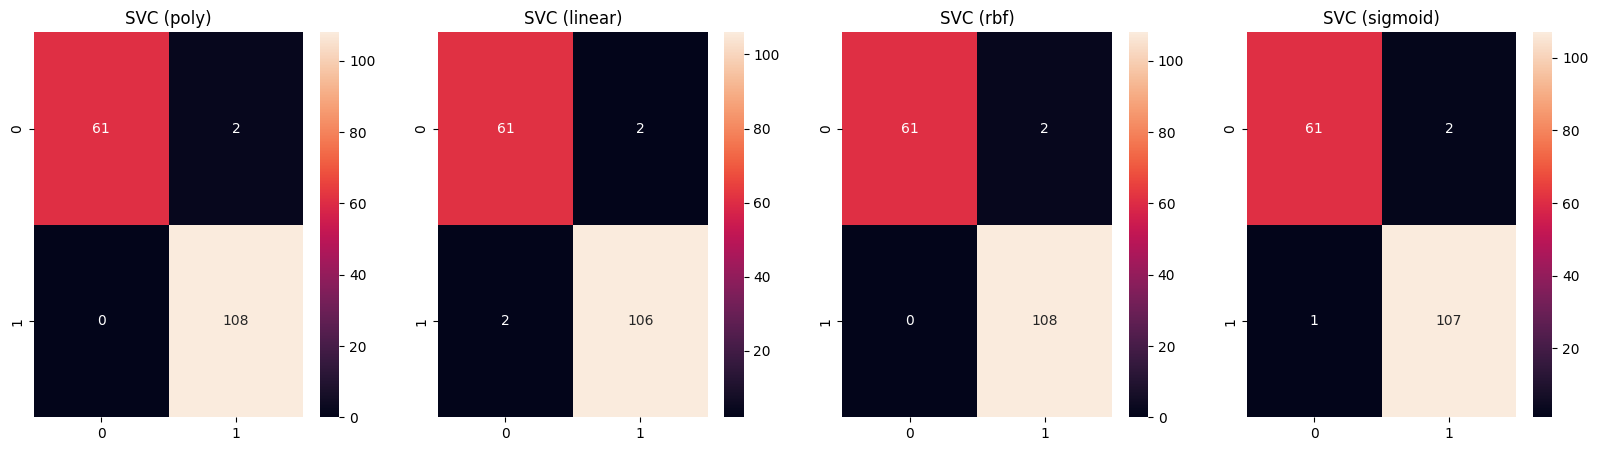

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, model_name in enumerate(models.keys()):
    model = models[model_name]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axs[i])
    axs[i].set_title(model_name)

plt.show()

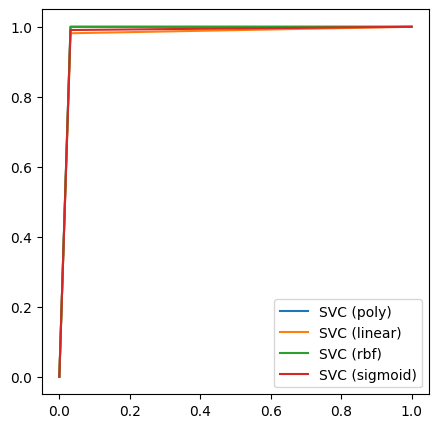

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fig, ax = plt.subplots(figsize=(5, 5))

for model_name in models.keys():
    model = models[model_name]
    y_pred = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    ax.plot(fpr, tpr, label=model_name)

plt.legend()
plt.show()


very similar AUC-ROC curves because, how we can see, the difference in AUC between the models is less than 0.1